<a href="https://colab.research.google.com/github/tamakoma1129/ClassificationOfDrumSound/blob/main/%E3%83%89%E3%83%A9%E3%83%A0%E9%9F%B3%E6%BA%90%E3%81%AE%E5%88%86%E9%A1%9E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

wav音声ファイルをMFCCファイルに変換

In [8]:
import os
import glob
import numpy as np
import librosa

#wavファイルをmfccにして、numpy配列で保存

# 対象とするフォルダのパスを指定
folder_path = "/content/drive/My Drive/..."

# フォルダ内の全てのwavファイルに対して処理を行います
for filename in glob.glob(os.path.join(folder_path, '*.wav')):
    # 音声ファイルの読み込み
    y, sr = librosa.load(filename, sr=None) #sr=Noneにすることでオリジナルサンプリングレートで読み込む

    # MFCCの計算
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13) #13次元を指定しているが、とりあえずなので後から修正も

    # MFCCsを'.npy'ファイルとして保存
    # ファイル名から拡張子を除いたものに'_mfccs.npy'を付けた名前で保存します
    np.save(os.path.splitext(filename)[0] + '_mfccs.npy', mfccs)

各データの長さを見る

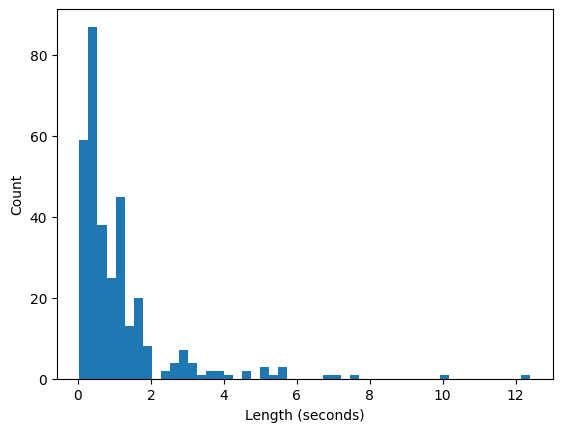

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import librosa

# すべてのファイルパスを取得します
file_paths = glob.glob(os.path.join("/content/drive/MyDrive/ドラム音源の分類/data", '*', '*.wav'))

# 各音声ファイルの長さ（秒）を格納するリスト
lengths = []

# 各ファイルの長さを計算します
for file_path in file_paths:
    y, sr = librosa.load(file_path, sr=None)
    length = librosa.get_duration(y=y, sr=sr)
    lengths.append(length)

# numpy arrayに変換します
lengths = np.array(lengths)

# ヒストグラムを表示します
plt.hist(lengths, bins=50)
plt.xlabel('Length (seconds)')
plt.ylabel('Count')
plt.show()
